1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Shirt Color: black (Time: 0.5346 sec)
Gender Prediction: male (raw: 0.6145) (Time: 1.8628 sec)
Glasses Prediction: no_glasses (raw: 0.6066) (Time: 1.5746 sec)
Total Time: 4.0678 sec


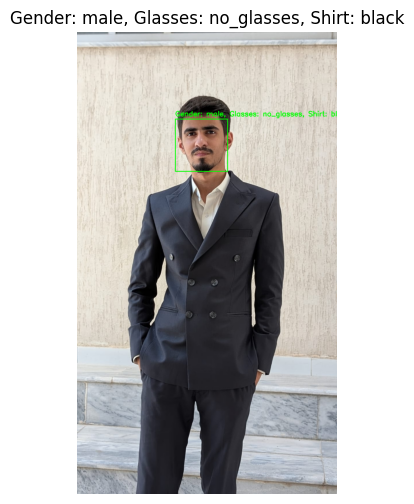

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
import time
from collections import Counter
from sklearn.cluster import KMeans
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# --- Load Models ---
gender_model = load_model("gender_classification_saved_model/best_model_finetuned.keras")
glasses_model = load_model("glasses_classification_saved_model/best_model_finetuned.keras")
gender_labels = ['female', 'male']
glasses_labels = ['glasses', 'no_glasses']

# --- Initialize MediaPipe ---
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)
mp_face = mp.solutions.face_detection

# --- Helper: Dominant Shirt Color ---
def get_dominant_color(image, k=3):
    pixels = image.reshape((-1, 3))
    kmeans = KMeans(n_clusters=k, n_init='auto')
    kmeans.fit(pixels)
    counts = Counter(kmeans.labels_)
    dominant_color = kmeans.cluster_centers_[counts.most_common(1)[0][0]]
    return tuple(map(int, dominant_color))

def rgb_to_color_name(rgb):
    color_names = {
        'red': (255, 0, 0), 'blue': (0, 0, 255), 'green': (0, 255, 0),
        'white': (255, 255, 255), 'black': (0, 0, 0), 'yellow': (255, 255, 0),
        'gray': (128, 128, 128), 'brown': (150, 75, 0), 'pink': (255, 192, 203),
        'orange': (255, 165, 0), 'purple': (128, 0, 128)
    }
    closest_name = min(color_names, key=lambda name: np.linalg.norm(np.array(rgb) - np.array(color_names[name])))
    return closest_name

# --- Main Function ---
def full_prediction(image_path):
    total_start = time.time()

    img = cv2.imread(image_path)
    if img is None:
        print("Failed to load image.")
        return

    h, w, _ = img.shape
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # --- Pose for Shirt Color ---
    shirt_start = time.time()
    pose_results = pose.process(image_rgb)
    if pose_results.pose_landmarks:
        lm = pose_results.pose_landmarks.landmark
        try:
            x1 = int(min(lm[11].x, lm[12].x) * w)
            x2 = int(max(lm[11].x, lm[12].x) * w)
            y1 = int(min(lm[11].y, lm[12].y) * h)
            y2 = int(max(lm[23].y, lm[24].y) * h)
            x1, x2 = max(0, x1 - 20), min(w, x2 + 20)
            y1, y2 = max(0, y1 - 20), min(h, y2 + 20)
            shirt_roi = img[y1:y2, x1:x2]

            dominant_rgb = get_dominant_color(shirt_roi)
            shirt_color = rgb_to_color_name(dominant_rgb)
        except:
            shirt_color = "undetected"
    else:
        shirt_color = "undetected"
    shirt_time = time.time() - shirt_start

    # --- Face Detection ---
    with mp_face.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detector:
        face_results = face_detector.process(image_rgb)
        if not face_results.detections:
            print("No face detected.")
            return

        bbox = face_results.detections[0].location_data.relative_bounding_box
        x = int(bbox.xmin * w)
        y = int(bbox.ymin * h)
        bw = int(bbox.width * w)
        bh = int(bbox.height * h)
        x, y = max(0, x), max(0, y)
        cropped_face = img[y:y + bh, x:x + bw]

        if cropped_face.size == 0:
            print("Cropped face is empty.")
            return

        face_resized = cv2.resize(cropped_face, (224, 224))
        face_rgb = cv2.cvtColor(face_resized, cv2.COLOR_BGR2RGB)
        face_array = np.expand_dims(img_to_array(face_rgb), axis=0)

        # Gender prediction
        gender_start = time.time()
        pred_gender = gender_model.predict(face_array)[0][0]
        gender = gender_labels[int(pred_gender > 0.5)]
        gender_time = time.time() - gender_start

        # Glasses prediction
        glasses_start = time.time()
        pred_glasses = glasses_model.predict(face_array)[0][0]
        glasses = glasses_labels[int(pred_glasses > 0.5)]
        glasses_time = time.time() - glasses_start

    total_time = time.time() - total_start

    # --- Results ---
    print(f"\nShirt Color: {shirt_color} (Time: {shirt_time:.4f} sec)")
    print(f"Gender Prediction: {gender} (raw: {pred_gender:.4f}) (Time: {gender_time:.4f} sec)")
    print(f"Glasses Prediction: {glasses} (raw: {pred_glasses:.4f}) (Time: {glasses_time:.4f} sec)")
    print(f"Total Time: {total_time:.4f} sec")

    # --- Visualize ---
    label = f"Gender: {gender}, Glasses: {glasses}, Shirt: {shirt_color}"
    cv2.rectangle(image_rgb, (x, y), (x + bw, y + bh), (0, 255, 0), 2)
    cv2.putText(image_rgb, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
                0.8, (0, 255, 0), 2)

    plt.figure(figsize=(8, 6))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title(label)
    plt.show()

# --- Test ---
image_path = "myimage3.jpg"
full_prediction(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

Shirt Color: black (Time: 0.3008 sec)
Gender Prediction: male (raw: 0.6422) (Time: 0.0912 sec)
Glasses Prediction: glasses (raw: 0.2960) (Time: 0.1015 sec)
Total Time: 0.6547 sec


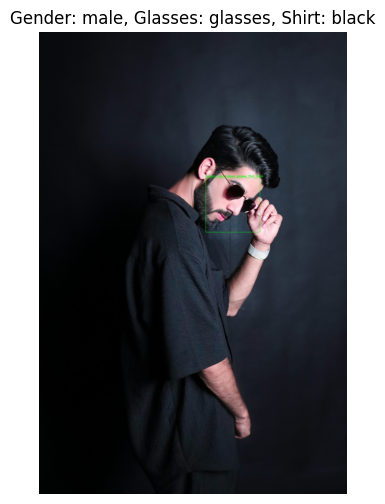

In [3]:
image_path = "image3.jpeg"
full_prediction(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step

Shirt Color: white (Time: 0.3830 sec)
Gender Prediction: female (raw: 0.2098) (Time: 0.1181 sec)
Glasses Prediction: glasses (raw: 0.1384) (Time: 0.1028 sec)
Total Time: 0.6891 sec


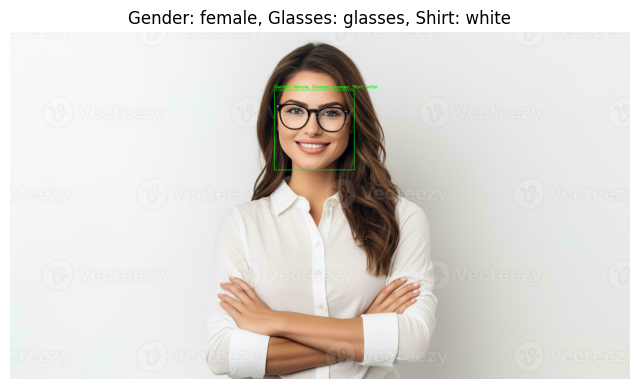

In [4]:
image_path = "imag34.jpeg"
full_prediction(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

Shirt Color: pink (Time: 0.0819 sec)
Gender Prediction: female (raw: 0.3910) (Time: 0.1086 sec)
Glasses Prediction: no_glasses (raw: 0.8334) (Time: 0.1013 sec)
Total Time: 0.3359 sec


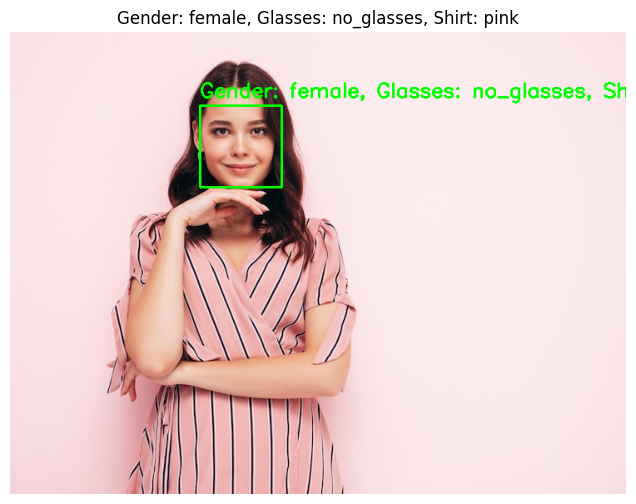

In [5]:
image_path = r"gender-dataset/female/image_322.jpg"  # Make sure path and slashes are correct
full_prediction(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

Shirt Color: gray (Time: 0.0970 sec)
Gender Prediction: female (raw: 0.3199) (Time: 0.1020 sec)
Glasses Prediction: no_glasses (raw: 0.7369) (Time: 0.1095 sec)
Total Time: 0.3630 sec


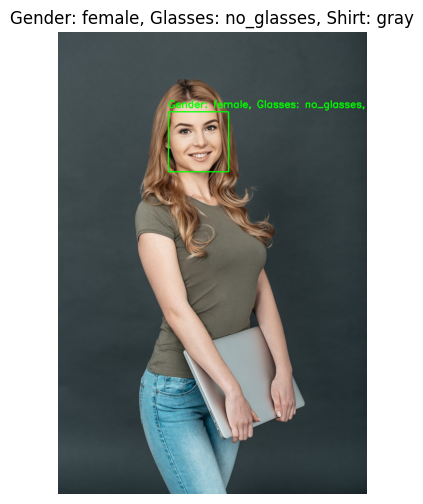

In [6]:
image_path = r"gender-dataset/female/image_35.jpg"  # Make sure path and slashes are correct
full_prediction(image_path)
